In [20]:
##########################Load Libraries  ####################################
import pandas as pd
import numpy as np

import random 

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchinfo import summary
import pandas as pd
import os

from tqdm import trange
import inspect
import time
import itertools

%matplotlib inline

from myUtils import *
from plottingUtils import *
from dataUtils import *

In [21]:
#hyperparameters

data_dir = "./datasets/PJM_power/"
fname = "DAYTON_hourly.csv"

sample_len = 48
step = 1
target_len = 12
batch_size = 64
steps_in_day = 24

HID_DIM = 64
RNN_LAYERS = 4
LIN_LAYERS = 2
DROPOUT = 0.5

learning_rate = 1e-5
epochs = 100

desired_features = None

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
print(torch.__version__)

Using cuda device
2.0.1+cu117


In [23]:
class Iterative(nn.Module):
    def __init__(self, n_features, hid_dim, rnn_layers, lin_layers, dropout, device):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = rnn_layers
        self.device = device

        self.rnn = nn.GRU(
            input_size=n_features,
            hidden_size=hid_dim,
            num_layers=rnn_layers,
            dropout=dropout,
            batch_first=True,
        )

        # create fc
        self.fc = nn.Sequential()
        for i in range(lin_layers):
            self.fc.add_module(
                f"lin{i}", nn.Linear(hid_dim * rnn_layers, hid_dim * rnn_layers)
            )
            self.fc.add_module(f"relu{i}", nn.LeakyReLU())
        self.fc.add_module(
            f"lin{lin_layers}", nn.Linear(hid_dim * rnn_layers, n_features)
        )

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src = [batch size, src len, n features]
        batch_size = src.shape[0]
        src_len = src.shape[1]
        output_len = trg.shape[1]
        outputs = torch.zeros_like(trg).to(self.device)
        sequence = torch.cat((src, outputs), dim=1).to(self.device)
        # sequence = [batch size, src len + output len, n features]
        

        for i in range(output_len):
            # evaluate the last src_len timesteps in the sequence
            _, hidden = self.rnn(sequence[:, i : (src_len + i)].contiguous())

            # hidden = [n layers, batch size, hid dim]

            hidden = hidden.permute(1, 0, 2).reshape(batch_size, -1)
            # hidden = [batch size, n layers * hid dim]

            # get the next value
            prediction = self.fc(hidden)

            # if we use teacher forcing, the next time step is the target
            teacher_force = random.random() < teacher_forcing_ratio and i < output_len - 1

            # append the value to the end of the sequence
            outputs[:, i] = trg[:, i] if teacher_force else prediction
            sequence[:, src_len + i] = outputs[:, i].clone()

        return outputs

In [24]:
def make_predictions(model, samples, targets, device):
    with torch.no_grad():
        output = model(samples.to(device), targets.to(device), teacher_forcing_ratio=0)
    return output

In [25]:
def train(
    dataloader,
    model,
    loss_fn,
    optimizer,
    iter_count=None,
    teacher_forcing_ratio=0.5,
    visibility=True,
):
    """
    dataloader: iterable
    model: model to train
    loss_fn: loss function
    optimizer: used optimizer
    iter_count: number of iterations, if None then dataloader length
    teacher_forcing_ratio: probability to use teacher forcing
    visibility: boolean, if True then show progress bar
    """
    assert not (
        inspect.isgenerator(dataloader) and iter_count is None
    ), "generator must have specified size"
    if iter_count is None:
        iter_count = len(dataloader.dataset)

    data_iterator = iter(dataloader)
    model.train()
    average_loss = 0

    r = trange(iter_count) if visibility else range(iter_count)
    torch.autograd.set_detect_anomaly(True)
    for _ in r:
        x, y = next(data_iterator)
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        
        pred = model(x, y, teacher_forcing_ratio=teacher_forcing_ratio)

        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        average_loss += loss.item()
    torch.autograd.set_detect_anomaly(False)
    average_loss /= iter_count

    return average_loss


In [26]:
def eval(
    dataloader, 
    model, 
    loss_fn, 
    iter_count=None, 
    desired_features=None, 
    visibility=True
):
    """
    dataloader: iterable
    model: model to train
    loss_fn: loss function
    iter_count: number of iterations, if None then dataloader length
    visibility: boolean, if True then show progress bar
    """
    if iter_count is None:
        iter_count = len(dataloader.dataset)
    data_iterator = iter(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        r = trange(iter_count) if visibility else range(iter_count)
        for _ in r:
            x, y = next(data_iterator)
            x, y = x.to(device), y.to(device)

            pred = model(x, y, teacher_forcing_ratio=0)

            test_loss += loss_fn(pred, y).item()

    test_loss /= iter_count

    return test_loss


In [27]:
def fit_model(
    model,
    train_dataloader,
    val_dataloader,
    loss_fn,
    optimizer,
    scheduler,
    epochs=5,
    train_iter_count=None,
    val_iter_count=None,
    teacher_forcing_ratio=0.5,
    visibility = 0,
    save_model = False
):
    '''
    model: model to train
    train_dataloader: iterable
    val_dataloader: iterable
    loss_fn: loss function
    optimizer: used optimizer
    scheduler: used scheduler
    epochs: number of epochs
    train_iter_count: number of training iterations
    val_iter_count: number of validation iterations
    teacher_forcing_ratio: probability to use teacher forcing
    visibility: 0 - no progress bar, 1 - progress bar for entire training, 2 - progress bar for each epoch
    save_model: boolean, if True then save model with lowest validation loss
    '''
    history = {
        "train": {"loss": []},
        "val": {"loss": []},
    }
    total_time_start = time.time()
    r = trange(epochs) if visibility == 1 else range(epochs)

    min_val_loss = np.inf

    for t in r:
        if visibility == 2:
            print(f"Epoch {t+1}\n-------------------------------")
            print("Test")
        train_loss = train(
            train_dataloader,
            model,
            loss_fn=loss_fn,
            optimizer=optimizer,
            iter_count=train_iter_count,
            teacher_forcing_ratio=teacher_forcing_ratio,
            visibility=(visibility == 2),
        )
        if visibility == 2:
            print("Eval")
        val_loss = eval(
            val_dataloader,
            model,
            loss_fn=loss_fn,
            iter_count=val_iter_count,
            visibility=(visibility == 2),
        )
        scheduler.step(val_loss)
        
        if min_val_loss > val_loss and save_model:
            min_val_loss = val_loss
            torch.save(model, "model.pth")
        if visibility == 2:
            print(f"Train Error: Avg loss: {train_loss:>8f} ")
            print(f"Test Error: Avg loss: {val_loss:>8f} \n")
        if visibility == 1:
            r.set_postfix({"Avg": f"{val_loss:.4f}", "Min": f"{min_val_loss:.4f}"})
        history["train"]["loss"].append(train_loss)
        history["val"]["loss"].append(val_loss)

    total_time_end = time.time()
    total_duration = total_time_end - total_time_start
    
    average_duration = total_duration / epochs
    if visibility != 0:
        print(f"Total Duration: {print_duration(total_duration)}")
        print(f"Average Duration: {print_duration(average_duration)}")

    
    return history

In [28]:
def run_fit_model(
    data,
    device,
    sample_len=120,
    target_len=24,
    step=1,
    batch_size=64,
    HID_DIM=64,
    RNN_LAYERS=4,
    LIN_LAYERS=2,
    DROPOUT=0.5,
    learning_rate=1e-3,
    epochs=100,
    verbose=False,
):
    # hyperparameters
    N_FEATURES = data.shape[1]
    # generators
    train_generator, val_generator = get_dataset_generators(
        data,
        sample_len,
        target_len,
        step,
        batch_size,
        shuffle=True,
    )

    if verbose:
        # print a sample
        samples, targets = next(train_generator)
        for feature in range(samples.shape[-1]):
            plot_samples(samples, targets, feature, figsize=(15, 1))

    # instantiate model

    N_FEATURES = data.shape[1]

    model = Iterative(
        n_features=N_FEATURES,
        device=device,
        hid_dim=HID_DIM,
        rnn_layers=RNN_LAYERS,
        lin_layers=LIN_LAYERS,
        dropout=DROPOUT,
    ).to(device)


    if verbose:
        # print model
        print(model)
        print(
            summary(
                model,
                input_size=[(10, sample_len, N_FEATURES),(10, target_len, N_FEATURES)],
                col_names=[
                    "input_size",
                    "output_size",
                    "num_params",
                    "trainable",
                    "kernel_size",
                ],
                col_width=15,
            )
        )
    # Fit model

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.1, patience=10
    )
    
    history = fit_model(
        model,
        train_dataloader=train_generator,
        train_iter_count=200,
        val_dataloader=val_generator,
        val_iter_count=100,
        loss_fn=loss_fn,
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=epochs,
        save_model=True,
        visibility=(1 if verbose else 0),
    )
    if verbose:
        plot_history(history)
    # get min loss
    best_model = torch.load("model.pth")
    return best_model, history

In [29]:
def evaluate_parameters(
    data,
    device,
    num_runs_per_config=1,
    sample_len_list = [sample_len],
    target_len_list = [target_len],
    step_list = [step],
    batch_size_list = [batch_size],
    hiddim_list = [HID_DIM],
    rnn_layers_list = [RNN_LAYERS],
    lin_layers_list = [LIN_LAYERS],
    dropout_list = [DROPOUT],
    learning_rate_list = [learning_rate],
    epochs_list = [epochs],
):
    configurations = list(itertools.product(
        sample_len_list,
        target_len_list,
        step_list,
        batch_size_list,
        hiddim_list,
        rnn_layers_list,
        lin_layers_list,
        dropout_list,
        learning_rate_list,
        epochs_list,
    ))

    for configuration in configurations:
        sample_len, target_len, step, batch_size, hid_dim, rnn_layers, lin_layers, dropout, learning_rate, epochs = configuration
        

        print("Sample length:", sample_len, "Target length:", target_len, "Step size", step, "Batch size", batch_size)
        print("HID dim:", hid_dim, "RNN layers:", rnn_layers, "Lin layers:", lin_layers, "Dropout:", dropout)
        print("Learning rate:", learning_rate, "Epochs:", epochs)
        min_val_loss = np.inf
        for _ in trange(num_runs_per_config):
            
            
            _, history = run_fit_model(
                data,
                device,
                sample_len,
                target_len,
                step,
                batch_size,
                hid_dim,
                rnn_layers,
                lin_layers,
                dropout,
                learning_rate,
                epochs,
                verbose=False,
            )
            min_val_loss = min(min(history["val"]["loss"]), min_val_loss)
        
        print("______ Min validation loss:", round(min_val_loss,5))
        print("__________________________________________________")


In [30]:
# preprocessing


df = extract_dataframe(data_dir, fname)
#df = add_features(df, steps_in_day=steps_in_day)

header, float_data = extract_data(df)
normalized_data, mean, std = normalize_data(float_data)

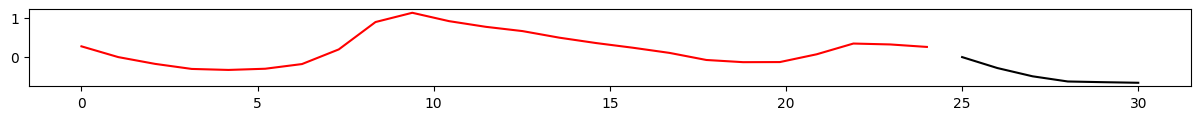

Iterative(
  (rnn): GRU(1, 64, num_layers=4, batch_first=True, dropout=0.5)
  (fc): Sequential(
    (lin0): Linear(in_features=256, out_features=256, bias=True)
    (relu0): LeakyReLU(negative_slope=0.01)
    (lin1): Linear(in_features=256, out_features=256, bias=True)
    (relu1): LeakyReLU(negative_slope=0.01)
    (lin2): Linear(in_features=256, out_features=1, bias=True)
  )
)
Layer (type:depth-idx)                   Input Shape     Output Shape    Param #         Trainable       Kernel Shape
Iterative                                [10, 24, 1]     [10, 6, 1]      --              True            --
├─GRU: 1-1                               [10, 24, 1]     [10, 24, 64]    87,744          True            --
├─Sequential: 1-2                        [10, 256]       [10, 1]         --              True            --
│    └─Linear: 2-1                       [10, 256]       [10, 256]       65,792          True            --
│    └─LeakyReLU: 2-2                    [10, 256]       [10, 256] 

100%|██████████| 100/100 [38:07<00:00, 22.87s/it, Avg=0.0413, Min=0.0383]


Total Duration: 0:38:7.325
Average Duration: 0:0:22.873
History:


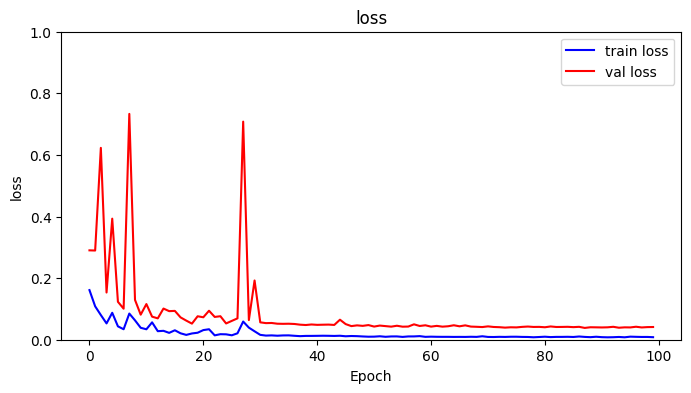

In [31]:
model, history = run_fit_model(
    normalized_data,
    device, 
    verbose=True,
    sample_len=24,
    target_len=6,
    HID_DIM=64,
)

History:


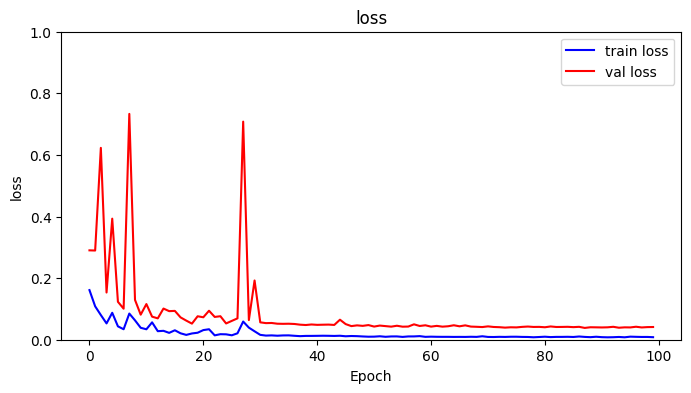

In [32]:
plot_history(history)

In [33]:
def run_make_predictions(model, data, device, num_preds=5, sample_len=sample_len, target_len=target_len, step=step, batch_size=batch_size):
    _, val_generator = get_dataset_generators(
        data,
        sample_len,
        target_len,
        step,
        batch_size,
        shuffle=True,
    )
    
    for _ in range(num_preds):
        samples, targets = next(val_generator)
        output = make_predictions(model, samples, targets, device)
        plot_predictions(header, samples, targets, output, mean, std)

DAYTON_MW


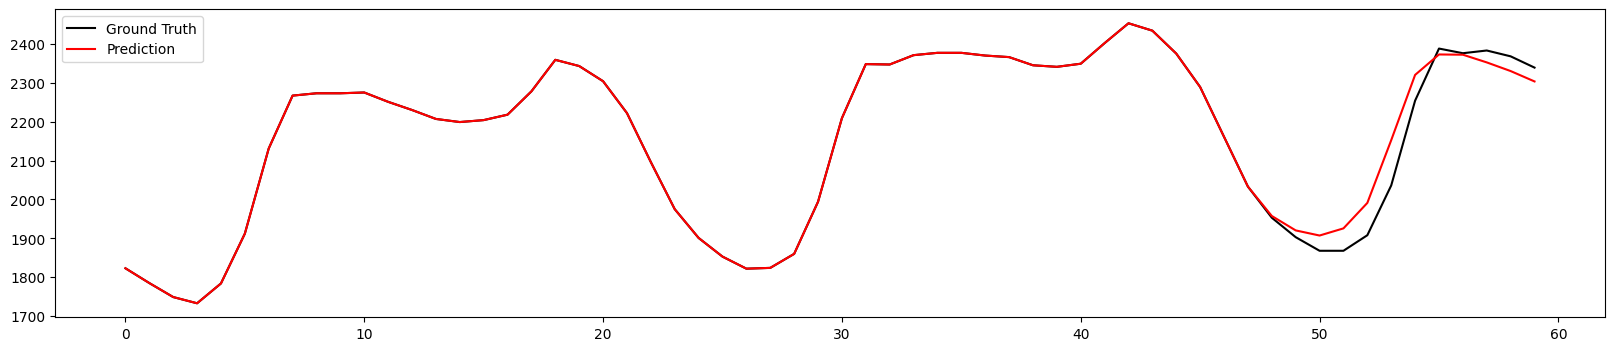

DAYTON_MW


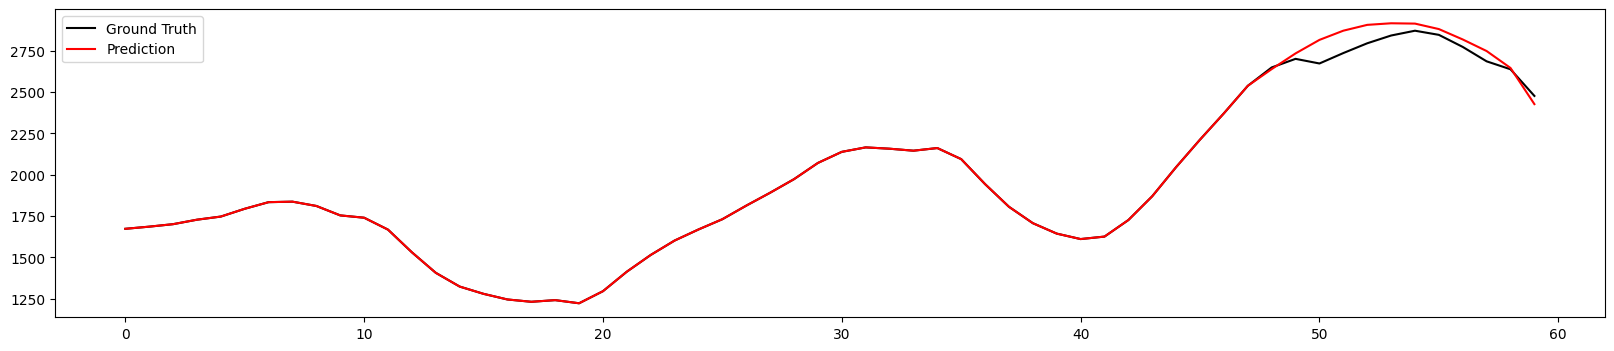

DAYTON_MW


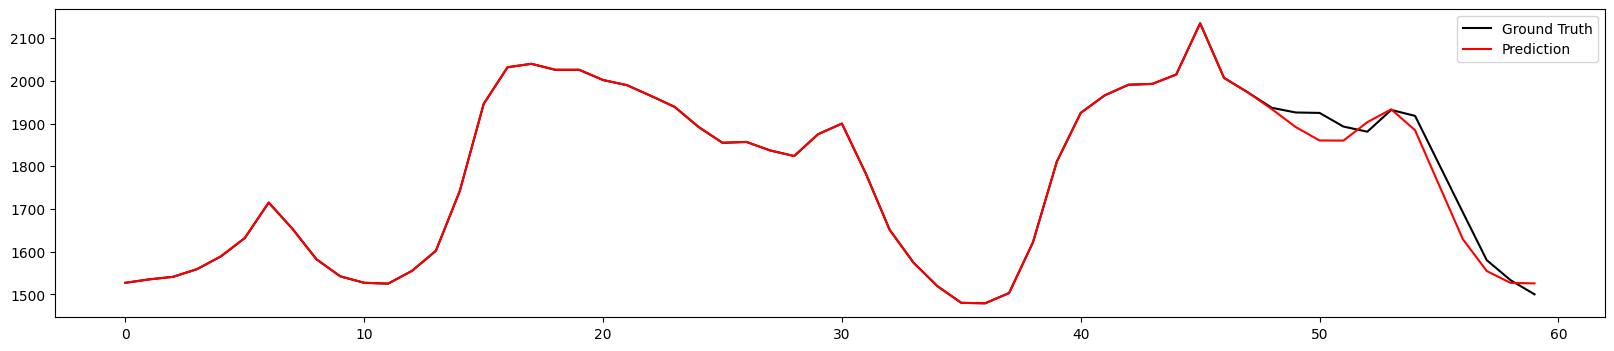

DAYTON_MW


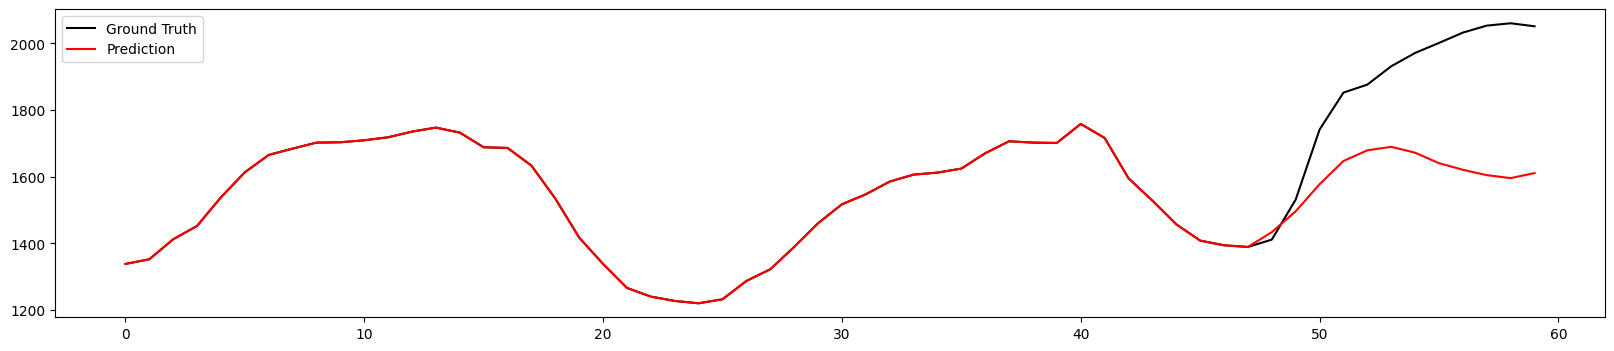

DAYTON_MW


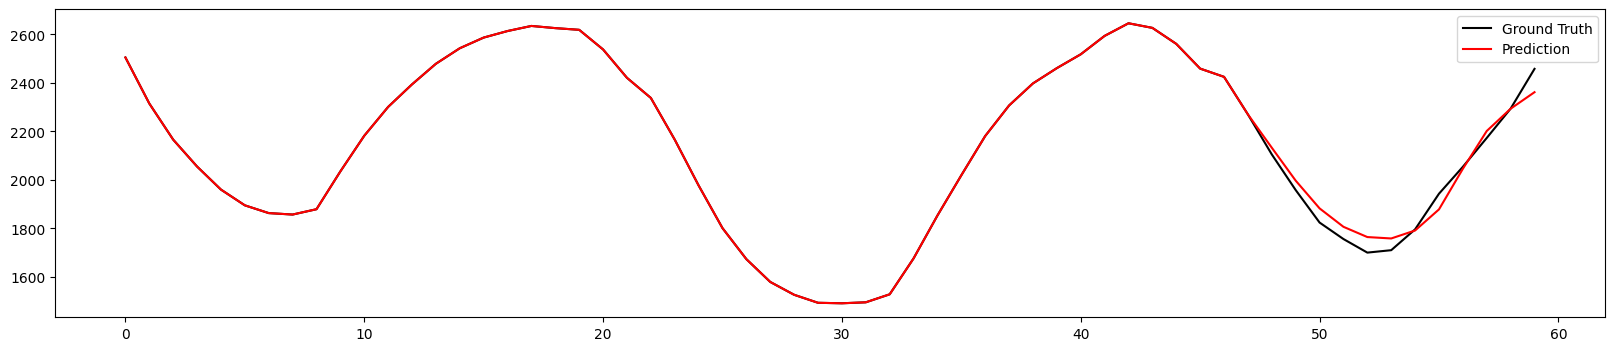

In [34]:
run_make_predictions(model, normalized_data, device, num_preds=5)